In [1]:
%load_ext nb_black
# !pip install nb_black
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics as m
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE  # doctest: +NORMALIZE_WHITESPACE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from mlxtend.feature_selection import ColumnSelector
from sklearn import model_selection
from mlxtend.classifier import StackingClassifier
from thundersvm import SVC as svmgpu


Using TensorFlow backend.


<IPython.core.display.Javascript object>

In [3]:
randomseed = 7
np.random.seed(randomseed)

<IPython.core.display.Javascript object>

# 1. Read the dataset

In [4]:
x_original = pd.read_csv("XLable_onlyDiabeticRemoved.txt")

conditions = [
    (x_original.L100800 < 100),
    (x_original.L100800 >= 100) & (x_original.L100800 < 126),
    (x_original.L100800 >= 126),
]
choices = [0, 1, 2]
x_original["CLASS"] = np.select(conditions, choices, default=0)
x_original = x_original[
    [
        "Unnamed: 0",
        "L100800",
        "L104600",
        "L103000",
        "S000300",
        "L101700",
        "L100700",
        "FIELD_33",
        "FIELD_38",
        "FIELD_40",
        "FIELD_31",
        "SEX",
        "AGE",  #'CLASS',
        "FIELD_16",
        "FIELD_23",
        "FIELD_15",
        "FIELD_22",
        "FIELD_17",
        "FIELD_24",
    ]
]

print(x_original.shape)

(185843, 19)


<IPython.core.display.Javascript object>

In [5]:
y_original = pd.read_csv("TargetLable_onlyDiabeticRemoved.txt")

conditions = [
    (y_original.L100800 < 100),
    (y_original.L100800 >= 100) & (y_original.L100800 < 126),
    (y_original.L100800 >= 126),
]

choices = [0, 1, 2]
y_original["CLASS"] = np.select(conditions, choices, default=0)

y_original = y_original[["Unnamed: 0", "CLASS"]]

print(y_original.shape)

(185843, 2)


<IPython.core.display.Javascript object>

In [6]:
data = pd.merge(
    x_original, y_original, how="inner", left_on="Unnamed: 0", right_on="Unnamed: 0"
)

<IPython.core.display.Javascript object>

In [7]:
# filter the data set
data = data[data.FIELD_16 != 1]  # exclude people who are diagnosed for (diabetes)
data = data[data.FIELD_23 != 1]  # exclude people who are on medication for diabetes

data = data[
    data.FIELD_15 != 1
]  # exclude people who are diagnosed for (high blood pressure)
data = data[
    data.FIELD_22 != 1
]  # exclude people who are on medication for high blood pressure

data = data[data.FIELD_17 != 1]  # exclude people who are diagnosed for hyperlipidemia
data = data[
    data.FIELD_24 != 1
]  # exclude people who are on medication for hyperlipidemia

print(data.shape)

(169024, 20)


<IPython.core.display.Javascript object>

In [8]:
data = data[
    [
        "L100800",
        "L104600",
        "L103000",
        "S000300",
        "L101700",
        "L100700",
        "FIELD_33",
        "FIELD_38",
        "FIELD_40",
        "FIELD_31",
        "SEX",
        "AGE",
        "CLASS",
    ]
]
data = data.dropna()
print(data.shape)
data.head()

(56542, 13)


,L100800,L104600,L103000,S000300,L101700,L100700,FIELD_33,FIELD_38,FIELD_40,FIELD_31,SEX,AGE,CLASS
2,78.0,5.28,41.0,20.2,15.0,3.8,1.0,2.0,1.0,0.0,1.0,46.0,0
5,90.0,5.74,50.0,25.5,12.0,3.4,1.0,0.0,1.0,0.0,1.0,52.0,0
10,86.0,5.83,45.0,21.2,17.0,3.9,1.0,0.0,1.0,1.0,1.0,37.0,0
11,86.0,4.73,54.0,22.0,30.0,4.2,1.0,2.0,3.0,0.0,1.0,39.0,0
20,87.0,5.60,340.0,24.6,26.0,4.7,1.0,0.0,2.0,0.0,1.0,59.0,0


<IPython.core.display.Javascript object>

# 2. Downsample the majority class and upsample the minority

In [9]:
diabetic = data[data.CLASS == 2]
prediabetic = data[data.CLASS == 1]
normal = data[data.CLASS == 0]

print(diabetic.shape[0], prediabetic.shape[0], normal.shape[0])

1045 17331 38166


<IPython.core.display.Javascript object>

In [10]:
diabetic_test = diabetic.sample(200, random_state=randomseed)
prediabetic_test = prediabetic.sample(200, random_state=randomseed)
normal_test = normal.sample(200, random_state=randomseed)
test = pd.concat([diabetic_test, prediabetic_test, normal_test])

diabetic_train = diabetic.drop(diabetic_test.index)
prediabetic_train = prediabetic.drop(prediabetic_test.index)
# .sample(
#     10 * diabetic_train.shape[0], random_state=randomseed
# )
normal_train = normal.drop(normal_test.index).sample(
    prediabetic_train.shape[0],
    random_state=randomseed
    #     10 * diabetic_train.shape[0], random_state=randomseed
)
train = pd.concat([diabetic_train, diabetic_train, prediabetic_train, normal_train])

<IPython.core.display.Javascript object>

In [11]:
xtrain = train.iloc[:, :-1]
ytrain = train.iloc[:, -1]
xtest = test.iloc[:, :-1]
ytest = test.iloc[:, -1]

<IPython.core.display.Javascript object>

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

<IPython.core.display.Javascript object>

In [13]:
from imblearn.over_sampling import SMOTE, SMOTENC  # doctest: +NORMALIZE_WHITESPACE

randomseed = 42

sm = SMOTENC(
    random_state=randomseed,
    categorical_features=[6, 7, 8, 9, 10],
    sampling_strategy="minority",
)
X_res, y_res = sm.fit_resample(xtrain, ytrain)

print("Resampled dataset shape %s" % Counter(y_res))
print(
    y_res[y_res == 0].shape[0], y_res[y_res == 1].shape[0], y_res[y_res == 2].shape[0]
)
print(X_res.shape, y_res.shape)

xtrain = X_res
ytrain = y_res

Resampled dataset shape Counter({2: 17131, 1: 17131, 0: 17131})
17131 17131 17131
(51393, 12) (51393,)


<IPython.core.display.Javascript object>

# 3. Generate the classifier models based on the selected 12 features

# 3.1.  Features : 12

# a. Random forest

In [14]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# parameters = {
#     "max_features": ("auto", "sqrt", "log2"),
#     "n_estimators": [10, 100, 200, 700],
#     "max_depth": [2, 8, 10],
#     "min_samples_split": [2, 8, 12],
#     "min_samples_leaf": [2, 8, 12],
#     "criterion": ["gini", "entropy"],
# }

# rf_clf = RandomForestClassifier(n_jobs=-1, verbose=1)
# rf_clf = GridSearchCV(rf_clf, parameters)
# rf_clf.fit(xtrain, ytrain)

<IPython.core.display.Javascript object>

In [14]:
# rf_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

<IPython.core.display.Javascript object>

In [15]:
rf_12 = RandomForestClassifier(
    random_state=randomseed,
    n_estimators=100,
    max_depth=12,
    min_samples_split=2,
    min_samples_leaf=10,
    max_features="auto",
)

# # rf_12=rf_clf.best_estimator_
# rf_12 = RandomForestClassifier(
#     bootstrap=True,
#     class_weight=None,
#     criterion="gini",
#     max_depth=10,
#     max_features="log2",
#     max_leaf_nodes=None,
#     min_impurity_decrease=0.0,
#     min_impurity_split=None,
#     min_samples_leaf=2,
#     min_samples_split=12,
#     min_weight_fraction_leaf=0.0,
#     n_estimators=100,
#     n_jobs=-1,
#     oob_score=False,
#     random_state=None,
#     verbose=1,
#     warm_start=False,
# )

<IPython.core.display.Javascript object>

In [16]:
rf_12.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

<IPython.core.display.Javascript object>

In [17]:
ypred = rf_12.predict(xtest)
print("Accuracy = ", m.accuracy_score(ytest, ypred))

Accuracy =  0.7333333333333333


<IPython.core.display.Javascript object>

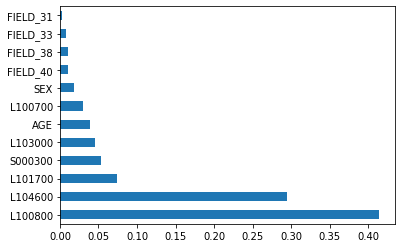

Index(['L100800', 'L104600', 'L101700', 'S000300', 'L103000', 'AGE', 'L100700',
       'SEX', 'FIELD_40', 'FIELD_38', 'FIELD_33', 'FIELD_31'],
      dtype='object')
[0.4138468  0.29414194 0.07415976 0.05276464 0.04540343 0.03864659
 0.03040461 0.01850657 0.01100423 0.01063041 0.0076764  0.00281463]


<IPython.core.display.Javascript object>

In [18]:
feat_importances = pd.Series(
    rf_12.feature_importances_, index=data.iloc[:, :-1].columns
)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(16).index)
print(feat_importances.nlargest(16).values)

In [19]:
confmatrx = pd.DataFrame(
    m.confusion_matrix(ytest, ypred),
    columns=["Normal", "Prediabetes", "diabetes"],
    index=["Normal", "Prediabetes", "diabetes"],
)
confmatrx.head()

,Normal,Prediabetes,diabetes
Normal,148,51,1
Prediabetes,55,127,18
diabetes,4,31,165


<IPython.core.display.Javascript object>

In [20]:
print(m.classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.71      0.74      0.73       200
           1       0.61      0.64      0.62       200
           2       0.90      0.82      0.86       200

    accuracy                           0.73       600
   macro avg       0.74      0.73      0.74       600
weighted avg       0.74      0.73      0.74       600



<IPython.core.display.Javascript object>

In [21]:
rf_ypred = rf_12.predict(xtest)
rf_ypredprob = rf_12.predict_proba(xtest)
rf_confmat = m.confusion_matrix(ytest, rf_ypred)

confsumh = np.sum(rf_confmat, axis=1)
propconfmat = rf_confmat.copy()
for i in range(propconfmat.shape[0]):
    propconfmat[i] = 100 * propconfmat[i] / confsumh[i]
rf_ypredconfprob_all = propconfmat / 100


print("====> original score, ",m.accuracy_score(ytest,rf_ypred))



====> original score,  0.7333333333333333


<IPython.core.display.Javascript object>

In [22]:
# from sklearn import model_selection

# scores = model_selection.cross_val_score(
#     rf_12, xtrain, ytrain, cv=5, scoring="accuracy"
# )
# print(
#     "Accuracy: %0.2f (+/- %0.2f) [%s] \n [%s]"
#     % (scores.mean(), scores.std(), "RandomForestClassifier", scores)
# )

<IPython.core.display.Javascript object>

# b. XGBOOST 

In [23]:
# parameters = {
#     "max_depth": [2, 8, 10],
#     "n_estimators": [10, 100, 700],
#     "learning_rate": [0.05, 0.15, 0.25],
#     "min_child_weight": [1, 3, 5],
#     "gamma": [0.0, 0.2, 0.4],
#     "colsample_bytree": [0.3, 0.4, 0.5],
# }
# xgb_clf = xgb.XGBClassifier()
# xgb_clf = RandomizedSearchCV(xgb_clf, parameters, verbose=2)
# xgb_clf.fit(xtrain, ytrain)
# xgb_clf.best_estimator_

<IPython.core.display.Javascript object>

In [24]:
import xgboost as xgb
from sklearn import metrics as m

xgb_model_12 = xgb.XGBClassifier(objective="binary:logistic", random_state=randomseed)
# objective="multi:softmax"
# objective="binary:logistic"
# xgb_model=xgb_clf.best_estimator_

# xgb_model=xgb_clf.best_estimator_
# xgb_model_12=xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=0.3, gamma=0.2,
#               learning_rate=0.05, max_delta_step=0, max_depth=10,
#               min_child_weight=5, missing=None, n_estimators=700, n_jobs=1,
#               nthread=None, objective='multi:softprob', random_state=0,
#               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
#               silent=None, subsample=1, verbosity=1)


<IPython.core.display.Javascript object>

In [26]:
xgb_model_12.fit(xtrain, ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

<IPython.core.display.Javascript object>

In [27]:
ypred = xgb_model_12.predict(xtest)
print("Accuracy = ", m.accuracy_score(ytest, ypred))

Accuracy =  0.735


<IPython.core.display.Javascript object>

In [28]:
confmatrx = pd.DataFrame(
    m.confusion_matrix(ytest, ypred),
    columns=["Normal", "Prediabetes", "diabetes"],
    index=["Normal", "Prediabetes", "diabetes"],
)
confmatrx.head()

,Normal,Prediabetes,diabetes
Normal,151,48,1
Prediabetes,59,116,25
diabetes,4,22,174


<IPython.core.display.Javascript object>

In [29]:
print(m.classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.71      0.76      0.73       200
           1       0.62      0.58      0.60       200
           2       0.87      0.87      0.87       200

    accuracy                           0.73       600
   macro avg       0.73      0.73      0.73       600
weighted avg       0.73      0.73      0.73       600



<IPython.core.display.Javascript object>

In [30]:
# scores = model_selection.cross_val_score(
#     xgb_model_12, xtrain, ytrain, cv=10, scoring="accuracy"
# )
# print(
#     "Accuracy: %0.2f (+/- %0.2f) [%s] \n [%s]"
#     % (scores.mean(), scores.std(), "xgb_model", scores)
# )

<IPython.core.display.Javascript object>

In [31]:
xgb_model_ypred = xgb_model_12.predict(xtest)
xgb_model_confmat = m.confusion_matrix(ytest, xgb_model_ypred)
xgb_model_ypredprob = xgb_model_12.predict_proba(xtest)
xgb_model_confmat = m.confusion_matrix(ytest, xgb_model_ypred)

confsumh = np.sum(xgb_model_confmat, axis=1)
propconfmat = xgb_model_confmat.copy()
for i in range(propconfmat.shape[0]):
    propconfmat[i] = 100 * propconfmat[i] / confsumh[i]
xgb_model_ypredconfprob_all = propconfmat / 100

<IPython.core.display.Javascript object>

In [32]:
print("====> original score, ", m.accuracy_score(ytest, xgb_model_ypred))

====> original score,  0.735


<IPython.core.display.Javascript object>

# c. SVM

In [26]:
from thundersvm import SVC as svmgpu

parameters = {
    "C": [0.1, 1, 10, 100, 1000],
    "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
    "kernel": ["linear", "rbf"],
}

SVC_clf = svmgpu()
SVC_clf2 = RandomizedSearchCV(SVC_clf, parameters, verbose=2)
SVC_clf2.fit(xtrain, ytrain)


# sorted(SVC_clf2.cv_results_.keys())

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] kernel=linear, gamma=0.0001, C=0.1 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... kernel=linear, gamma=0.0001, C=0.1, total=   2.8s
[CV] kernel=linear, gamma=0.0001, C=0.1 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] ............... kernel=linear, gamma=0.0001, C=0.1, total=   2.5s
[CV] kernel=linear, gamma=0.0001, C=0.1 ..............................
[CV] ............... kernel=linear, gamma=0.0001, C=0.1, total=   2.5s
[CV] kernel=rbf, gamma=0.001, C=1 ....................................
[CV] ..................... kernel=rbf, gamma=0.001, C=1, total=   2.5s
[CV] kernel=rbf, gamma=0.001, C=1 ....................................
[CV] ..................... kernel=rbf, gamma=0.001, C=1, total=   2.5s
[CV] kernel=rbf, gamma=0.001, C=1 ....................................
[CV] ..................... kernel=rbf, gamma=0.001, C=1, total=   2.5s
[CV] kernel=linear, gamma=0.1, C=1000 ................................
[CV] ................. kernel=linear, gamma=0.1, C=1000, total= 1.6min
[CV] kernel=linear, gamma=0.1, C=1000 ................................
[CV] ................. kernel=linear, gamma=0.1, C=1000, total= 1.7min
[CV] kernel=linear, gamma=0.1, C=1000 ................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 13.9min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=None, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovo',
                                 degree=3, gamma='auto', gpu_id=0, kernel='rbf',
                                 max_iter=-1, max_mem_size=-1, n_jobs=-1,
                                 probability=False, random_state=None,
                                 shrinking=False, tol=0.001, verbose=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['linear', 'rbf']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

<IPython.core.display.Javascript object>

In [27]:
SVC_clf2.best_estimator_

SVC(C=100, cache_size=None, class_weight={}, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=0.1, gpu_id=0,
    kernel='linear', max_iter=-1, max_mem_size=-1, n_jobs=-1, probability=False,
    random_state=None, shrinking=False, tol=0.001, verbose=False)

<IPython.core.display.Javascript object>

In [33]:
# scv_12=SVC_clf2.best_estimator_
scv_12 = svmgpu(
    C=100,
    cache_size=None,
    class_weight={},
    coef0=0.0,
    decision_function_shape="ovo",
    degree=3,
    gamma=0.1,
    gpu_id=0,
    kernel="linear",
    max_iter=-1,
    max_mem_size=-1,
    n_jobs=-1,
    probability=True,
    random_state=None,
    shrinking=False,
    tol=0.001,
    verbose=False,
)

<IPython.core.display.Javascript object>

In [34]:
# scv_12=SVC(C=70, cache_size=200, class_weight=None, coef0=0.0,
#     decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
#     kernel='linear', max_iter=-1, probability=True, random_state=42,
#     shrinking=True, tol=0.001, verbose=False)

<IPython.core.display.Javascript object>

In [35]:
scv_12.fit(xtrain, ytrain)

SVC(C=100, cache_size=None, class_weight={}, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=0.1, gpu_id=0,
    kernel='linear', max_iter=-1, max_mem_size=-1, n_jobs=-1, probability=True,
    random_state=None, shrinking=False, tol=0.001, verbose=False)

<IPython.core.display.Javascript object>

In [36]:
ypred = scv_12.predict(xtest)
print("Accuracy = ", m.accuracy_score(ytest, ypred))

Accuracy =  0.7366666666666667


<IPython.core.display.Javascript object>

In [37]:
confmatrx = pd.DataFrame(
    m.confusion_matrix(ytest, ypred),
    columns=["Normal", "Prediabetes", "diabetes"],
    index=["Normal", "Prediabetes", "diabetes"],
)
confmatrx.head()

,Normal,Prediabetes,diabetes
Normal,148,51,1
Prediabetes,53,122,25
diabetes,3,25,172


<IPython.core.display.Javascript object>

In [38]:
print(m.classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.73      0.74      0.73       200
           1       0.62      0.61      0.61       200
           2       0.87      0.86      0.86       200

    accuracy                           0.74       600
   macro avg       0.74      0.74      0.74       600
weighted avg       0.74      0.74      0.74       600



<IPython.core.display.Javascript object>

In [39]:
# scores = model_selection.cross_val_score(
#     scv_12, xtrain, ytrain, cv=10, scoring="accuracy"
# )
# print(
#     "Accuracy: %0.2f (+/- %0.2f) [%s] \n [%s]"
#     % (scores.mean(), scores.std(), "SVC_clf", scores)
# )

<IPython.core.display.Javascript object>

In [40]:
svc_ypred = scv_12.predict(xtest)
svc_confmat = m.confusion_matrix(ytest, svc_ypred)
svc_ypredprob = scv_12.predict_proba(xtest)
svc_confmat = m.confusion_matrix(ytest, svc_ypred)

confsumh = np.sum(svc_confmat, axis=1)
propconfmat = svc_confmat.copy()
for i in range(propconfmat.shape[0]):
    propconfmat[i] = 100 * propconfmat[i] / confsumh[i]
svc_ypredconfprob_all = propconfmat / 100

<IPython.core.display.Javascript object>

In [41]:
print("====> original score, ", m.accuracy_score(ytest, svc_ypred))

====> original score,  0.7366666666666667


<IPython.core.display.Javascript object>

# prepare the conf matrix

In [42]:
predprobalist = [rf_ypredprob, svc_ypredprob, xgb_model_ypredprob]
ypredconfprob_all = [
    rf_ypredconfprob_all,
    svc_ypredconfprob_all,
    xgb_model_ypredconfprob_all,
]

<IPython.core.display.Javascript object>

In [48]:

cimc2=np.zeros((600,3))
# # for each classifier
for j in range(3):
#     #for each data point    
    cimc=[]    
    for i in range(600):
        # print(i,ypredconfprob_all[j],predprobalist[j][i])
        
        c1=np.sum(predprobalist[j][i] * ypredconfprob_all[j][0])
        c2=np.sum(predprobalist[j][i] * ypredconfprob_all[j][1])
        c3=np.sum(predprobalist[j][i] * ypredconfprob_all[j][2])
        
        # print([c1,c2,c3])
        cimc.append([c1,c2,c3])
    
    cimc=np.array(cimc)
    ypred2=np.argmax(cimc,axis=1)
    # print((m.accuracy_score(ytest,ypred2)))§
    cimc2 = cimc2 + cimc
    
print("final cim ==== >")
cimc2=np.array(cimc2)
ypred3=np.argmax(cimc2,axis=1)
print((m.accuracy_score(ytest,ypred3))) 


final cim ==== >
0.7316666666666667


<IPython.core.display.Javascript object>

In [49]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

eclf1 = VotingClassifier(
    estimators=[("rf_12", rf_12), ("svcclf", scv_12), ("xgb_model_12", xgb_model_12)],
    voting="soft",
)
eclf1 = eclf1.fit(xtrain, ytrain)
eclf1_pred = eclf1.predict(xtest)
print(m.accuracy_score(ytest, eclf1_pred))

0.7333333333333333


<IPython.core.display.Javascript object>

In [55]:

# eclf2 = VotingClassifier(estimators=[
#         ("rf_12", rf_12), ("svcclf", scv_12) ], voting='hard')
# eclf2 = eclf2.fit(xtrain,ytrain)
# eclf2_pred=eclf2.predict(xtest)
# print(m.accuracy_score(ytest,eclf2_pred))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [79]:
temp = pd.DataFrame(data=np.array(ytest), columns=["ytest"])
temp["classifer1_RF"] = rf_ypred
temp["classifer2_svm"] = svc_ypred
temp["classifer3_XGBoost"] = xgb_model_ypred
temp["classifer4_CIM"] = ypred3
temp["classifer5_SoftVoting"] = eclf1_pred
temp.to_csv("diabetes_test.csv", index=False)
temp

,ytest,classifer1_RF,classifer2_svm,classifer3_XGBoost,classifer3_CIM,classifer3_SoftVoting
0,2,2,2.0,2,2,2
1,2,2,2.0,2,2,2
2,2,1,1.0,1,1,1
3,2,2,2.0,2,2,2
4,2,2,2.0,2,2,2
...,...,...,...,...,...,...
595,0,0,0.0,0,0,0
596,0,1,1.0,1,1,1
597,0,0,0.0,0,0,0
598,0,0,0.0,0,0,0


<IPython.core.display.Javascript object>

In [80]:
m.accuracy_score(temp.classifer2_svm, temp.classifer1_RF)

0.9483333333333334

<IPython.core.display.Javascript object>

In [81]:
m.accuracy_score(temp.classifer2_svm, temp.classifer3_XGBoost)

0.9566666666666667

<IPython.core.display.Javascript object>

In [82]:
m.accuracy_score(temp.classifer3_XGBoost, temp.classifer1_RF)

0.9516666666666667

<IPython.core.display.Javascript object>